In [1]:
import scipy.io
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class WaterQualityDataset(Dataset):
    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file containing the dataset.
            train (bool): If True, load training data; otherwise load test data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the .mat file
        data = scipy.io.loadmat(mat_file)
        self.transform = transform

        # Process location group information
        # location_group is a 1x3 cell array: each cell contains the indices of stations in that group
        location_group = data['location_group']  # shape: (1, 3)
        location_ids = data['location_ids'].flatten()  # shape: (37,)
        num_stations = len(location_ids)  # should be 37

        # Create an array to store the group ID for each station
        group_ids = np.zeros(num_stations, dtype=np.float32)
        for i in range(location_group.shape[1]):
            # Each cell contains an array of station indices (MATLAB indices are 1-based)
            station_indices = location_group[0, i].flatten() - 1  # convert to 0-based index
            group_ids[station_indices] = i + 1  # assign group number (1, 2, 3)

        self.group_ids = group_ids

        # Load training or testing data based on flag
        if train:
            X_data = data['X_tr']  # shape: (1, 423), each cell is 37x11
            Y_data = data['Y_tr']  # shape: (37, 423)
        else:
            X_data = data['X_te']  # shape: (1, 282), each cell is 37x11
            Y_data = data['Y_te']  # shape: (37, 282)

        # Convert cell arrays into lists for easier iteration
        self.X_list = [X_data[0, i] for i in range(X_data.shape[1])]
        self.Y_list = [Y_data[:, i] for i in range(Y_data.shape[1])]

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        # Get input and target: X shape (37, 11), Y shape (37,)
        x = self.X_list[idx]
        y = self.Y_list[idx]

        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Build column vector of group IDs (shape: (37,) -> (37, 1))
        group_col = torch.tensor(self.group_ids, dtype=torch.float32).unsqueeze(1)
        # Concatenate group info to original features -> new shape (37, 12)
        x = torch.cat((x, group_col), dim=1)

        # Add channel dimension for CNN input -> final shape (1, 37, 12)
        x = x.unsqueeze(0)

        if self.transform:
            x = self.transform(x)

        return x, y

In [4]:
class WaterQualityTransformer(nn.Module):
    def __init__(self, feature_dim=12, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(WaterQualityTransformer, self).__init__()

        # Input projection: (feature_dim) -> (d_model)
        self.input_proj = nn.Linear(feature_dim, d_model)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, 37, d_model))  # (batch, seq_len, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection: (d_model) -> (1 value per station)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: (batch_size, 1, 37, 12)
        batch_size = x.size(0)

        x = x.squeeze(1)  # remove channel dimension -> (batch_size, 37, 12)

        x = self.input_proj(x)  # -> (batch_size, 37, d_model)
        x = x + self.positional_encoding  # Add positional encoding

        x = self.transformer_encoder(x)  # -> (batch_size, 37, d_model)

        x = self.output_proj(x)  # -> (batch_size, 37, 1)
        x = x.squeeze(-1)  # -> (batch_size, 37)

        return x

In [5]:
def visualize_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        # Get a random batch from the test set
        sample_x, sample_y = random.choice(list(test_loader))
        sample_x = sample_x.to(device)
        sample_y = sample_y.to(device)
        predictions = model(sample_x)
        
        # Convert predictions and true values to numpy arrays
        predictions_np = predictions.cpu().numpy()
        true_np = sample_y.cpu().numpy()
    
    # Print comparison for the first sample in the batch
    print("Comparison for the first sample in the batch:")
    for station_idx in range(true_np.shape[1]):
        print(f"Station {station_idx+1:2d}: True = {true_np[0, station_idx]:.4f}, Predicted = {predictions_np[0, station_idx]:.4f}")
    
    # Plot the true vs. predicted values for the first sample
    plt.figure(figsize=(10, 5))
    plt.plot(true_np[0], label="True", marker='o')
    plt.plot(predictions_np[0], label="Predicted", marker='x')
    plt.title("True vs Predicted Water Quality Values")
    plt.xlabel("Station Index")
    plt.ylabel("Water Quality (pH)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
# File path for the dataset
mat_file_path = 'water_dataset.mat'

# Load dataset
train_dataset = WaterQualityDataset(mat_file_path, train=True)
test_dataset = WaterQualityDataset(mat_file_path, train=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WaterQualityTransformer().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# Train
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

# Evaluate
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Epoch [1/20], Train Loss: 0.2097
Epoch [2/20], Train Loss: 0.0106
Epoch [3/20], Train Loss: 0.0044
Epoch [4/20], Train Loss: 0.0036
Epoch [5/20], Train Loss: 0.0034
Epoch [6/20], Train Loss: 0.0030
Epoch [7/20], Train Loss: 0.0029
Epoch [8/20], Train Loss: 0.0027
Epoch [9/20], Train Loss: 0.0025
Epoch [10/20], Train Loss: 0.0024
Epoch [11/20], Train Loss: 0.0022
Epoch [12/20], Train Loss: 0.0021
Epoch [13/20], Train Loss: 0.0020
Epoch [14/20], Train Loss: 0.0018
Epoch [15/20], Train Loss: 0.0017
Epoch [16/20], Train Loss: 0.0016
Epoch [17/20], Train Loss: 0.0016
Epoch [18/20], Train Loss: 0.0015
Epoch [19/20], Train Loss: 0.0014
Epoch [20/20], Train Loss: 0.0014
Test Loss: 0.0006


Comparison for the first sample in the batch:
Station  1: True = 0.6019, Predicted = 0.6522
Station  2: True = 0.6204, Predicted = 0.6669
Station  3: True = 0.6111, Predicted = 0.6592
Station  4: True = 0.6296, Predicted = 0.6776
Station  5: True = 0.6667, Predicted = 0.6792
Station  6: True = 0.6111, Predicted = 0.6601
Station  7: True = 0.6389, Predicted = 0.6541
Station  8: True = 0.6574, Predicted = 0.6932
Station  9: True = 0.6759, Predicted = 0.7164
Station 10: True = 0.6574, Predicted = 0.6478
Station 11: True = 0.6574, Predicted = 0.6598
Station 12: True = 0.6759, Predicted = 0.6733
Station 13: True = 0.6574, Predicted = 0.6644
Station 14: True = 0.6481, Predicted = 0.6547
Station 15: True = 0.6296, Predicted = 0.6544
Station 16: True = 0.6574, Predicted = 0.6787
Station 17: True = 0.6481, Predicted = 0.6584
Station 18: True = 0.6759, Predicted = 0.6885
Station 19: True = 0.6667, Predicted = 0.6750
Station 20: True = 0.6481, Predicted = 0.6504
Station 21: True = 0.6204, Predict

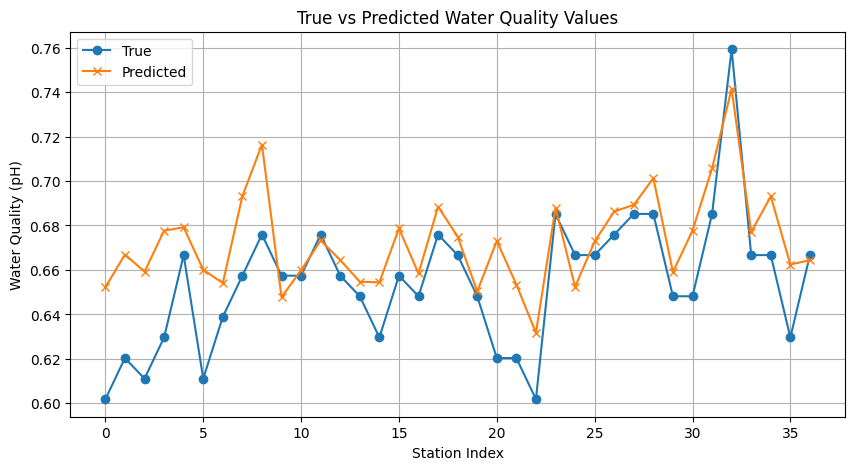

In [8]:
visualize_predictions(model, test_loader, device)

In [9]:
def compute_metrics(model, data_loader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())

    preds = torch.cat(all_preds, dim=0)  # (num_samples, 37)
    targets = torch.cat(all_targets, dim=0)  # (num_samples, 37)

    mse = torch.mean((preds - targets) ** 2)
    rmse = torch.sqrt(mse)

    mae = torch.mean(torch.abs(preds - targets))

    # Calculate range over all targets (max - min)
    target_range = torch.max(targets) - torch.min(targets)
    nrmse = rmse / target_range
    nmae = mae / target_range

    return {
        'RMSE': rmse.item(),
        'NRMSE': nrmse.item(),
        'MAE': mae.item(),
        'NMAE': nmae.item()
    }

In [10]:
compute_metrics(model, test_loader, device)

{'RMSE': 0.024557260796427727,
 'NRMSE': 0.057656180113554,
 'MAE': 0.018337048590183258,
 'NMAE': 0.043052203953266144}